Author: Bianca M. Massacci

## Import packages

In [1]:
# Import packages
print("---------IMPORTING PACKAGES---------")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import tensorflow as tf
import seaborn as sns
import random
import csv

from sklearn.utils import shuffle
from matplotlib import image
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Suppress keras warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
random.seed(432)

---------IMPORTING PACKAGES---------


## Define variables that will apply to all models:

In [2]:
# input and output folder
input_folder = "/kaggle/input/"
output_folder = "/kaggle/working/"

n_epochs = 60
batch_size = 128 # How big of a set of data to use for every training epoch
verbose = 0 # 0-> dont print model training info, 1-> print them

### Create a file to save test results

In [3]:
# Open the excel file where I'll save all the test results (metrics)

with open("./results.csv", "w") as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    # Create a row with the column names:
    filewriter.writerow(["model_name",
                         "removed_layer", 
                         "test_loss",
                         "test_accuracy",
                         "wa_precision", # wa = weighted average
                         "wa_recall",
                         "wa_f1_score",
                         "wrong_preds",
                         "total_preds",
                         "batch_size",
                         "num_train", # number of images in the training set
                         "num_val", # number of images in the validation set
                         "num_test", # number of images in the test set
                         "num_epochs_set", # cap set for num epochs
                         "num_epochs_run" # epoch where it stopped automatically
                        ])

### Define functions

In [4]:
# https://stackoverflow.com/questions/39280813/visualization-of-convolutional-layer-in-keras-model
# Merdan Memtimin https://stackoverflow.com/users/6565409/merdan-memtimin
def plot_conv_weights(model, layer_name):
    W = model.get_layer(name=layer_name).get_weights()[0]
    if len(W.shape) == 4:
        W = np.squeeze(W)
        W = W.reshape((W.shape[0], W.shape[1], W.shape[2]*W.shape[3])) 
        fig, axs = plt.subplots(5,5, figsize=(8,8))
        fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
        for i in range(25):
            axs[i].imshow(W[:,:,i])
            axs[i].set_title(str(i))

In [5]:
def load_metadata(data_folder, train_file, validation_file, test_file, column_names):
    """Reads the .csv files containing metadata (e.g. file location, class label) about the data images.
    
    Parameters:
    data_folder (str): file path to the folder containing the csv file.
    train_file (str): file name of the file containing metadata for the training set.
    validation_file (str): file name of the file containing metadata for the validation set.
    test_file (str): file name of the file containing metadata for the test set.
    column_names (list): array containing the column names for the csv files
    
    Returns:
    the read trainig, validation, and test files.
    """
    training_df = pd.read_csv(data_folder + train_file, names = column_names, skiprows=1)
    validation_df = pd.read_csv(data_folder + validation_file, names = column_names, skiprows=1)
    test_df = pd.read_csv(data_folder + test_file, names = column_names, skiprows=1)
    
    return training_df, validation_df, test_df


In [6]:
def precision(confusion_matrix):
    """Given a confusion matrix, calculates and returns precision for all classes"""
    precision_list = []
    for i in range(confusion_matrix.shape[1]):
        current_col = confusion_matrix[:,[i]]
        current_el = confusion_matrix[i,[i]]
        current_precision = (float(current_el/sum(current_col)[0]))
        current_precision = round(current_precision, 4)
        precision_list.append(current_precision)
    return precision_list

def recall(confusion_matrix):
    """Given a confusion matrix, calculates and returns recall for all classes"""
    recall_list = []
    for i in range(confusion_matrix.shape[0]):
        current_row = confusion_matrix[i,:]
        current_el = confusion_matrix[i,i]
        current_recall = round(current_el/sum(current_row), 4)
        recall_list.append(current_recall)
    return(recall_list)

def f1_score(precision, recall):
    """Given a list of precision and recall values for a certain matrix,
    returns f-1 values for each class"""
    f1_scores = []
    if len(precision) == len(recall):
        for i in range(len(precision)):
            current_f1 = 2*(precision[i]*recall[i])/(precision[i]+recall[i])
            f1_scores.append(round(current_f1, 4))
    else:
        print("Error. Precision and Recall lists should be of equal lengths.")
    return f1_scores

## Load data

In [7]:
print("---------LOADING DATA---------")
dataset_folder = input_folder + "eurosat-dataset/" + "EuroSAT/"
column_names =  ["id", "path", "class_id", "class_name"]

training_df, validation_df, test_df = load_metadata(dataset_folder,
                                                    "train.csv",
                                                    "validation.csv",
                                                    "test.csv",
                                                    column_names)

---------LOADING DATA---------


## Preprocessing

In [8]:
# The data is already normalized so that pixels values range from 0,255. We can rescale pixel value between
# [0,1] by divinding by 255.

rescaling_factor = 1. / 255
# Generate batches of tensor image data by setting up the generators.
# If you want to perform augmentation, add parameters to the training_generatorF
training_generator = ImageDataGenerator(rescale=rescaling_factor)
test_generator = ImageDataGenerator(rescale=rescaling_factor)

# Size of input data is 64x64 pixels
image_width, image_height = (64, 64)

In [9]:
print("Building training set.")
training_set = training_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False, # for replicability. Anyways they are already shuffled.
)

print("\nBuilding validation set.")
validation_set = test_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

print("\nBuilding test set")
test_set = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Building training set.
Found 18900 validated image filenames belonging to 10 classes.

Building validation set.
Found 5400 validated image filenames belonging to 10 classes.

Building test set
Found 2700 validated image filenames belonging to 10 classes.


In [10]:
class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)

class_count = len(class_name_list)

# Ablation
For this ablations study, I am going to focus on VGG16, as it is a simpler model than the models proposed by the EuroSAT original paper, but still a deep model with which I achived very close to State-of-the-Art (SoA) performance.

In [11]:
print("---------START OF ABLATION EXPERIMENTS---------")

---------START OF ABLATION EXPERIMENTS---------


## VGG16, the Original

In [12]:
print("---------START OF ORIGINAL MODEL---------")

model_name = "base_vgg16"
model = Sequential()

# start of model
model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# add a flatten out layer, a dropout for regularization, a FC layer, and a final
# 10-node softmax layer for the prediction.
model.add(Flatten()) # just flattening operation, same numb. nodes kept
# n. nodes chosen by keeping the drop in nodes ratio of the origina model (approx.)
model.add(Dense(units=680, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5)) # MY ADDITION
model.add(Dense(units=180, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))


---------START OF ORIGINAL MODEL---------


In [13]:
# model.summary()

In [14]:
model_path = "/kaggle/working/eurosat_rgb_" + model_name + ".h5"

# Save the weigths of the best model
checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)

# Reduce learning rate when val_loss stops improving for 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

# Stop training if a val_loss has stopped improving for 5 epochs.
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=verbose)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [15]:
print("---------MODEL COMPILE---------")

model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

---------MODEL COMPILE---------


In [16]:
print("---------MODEL FIT---------")

history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=n_epochs,
    verbose=0,
)

# Get the number of epochs the model ran for (to track early stopping):
n_ran_epochs = len(history.history['loss'])

---------MODEL FIT---------


In [17]:
#plot_conv_weights(model, "conv2d_35")

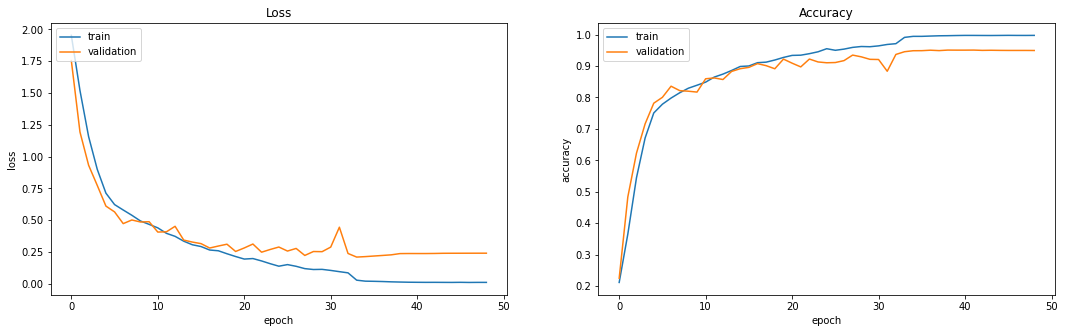

<Figure size 432x288 with 0 Axes>

In [18]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

plt.show()
plt.savefig(output_folder + model_name + "_training_curves.png")

## Predict and Evaluate Model

In [19]:
print("---------MODEL EVALUATE---------")

---------MODEL EVALUATE---------


In [20]:
loss, accuracy = model.evaluate(test_set, verbose=verbose)

In [21]:
test_set.reset()
predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=verbose)
# Computation is done in batches.
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)

In [22]:
print(metrics.classification_report(test_set.labels, predicted_class_ids, digits=4))
report = metrics.classification_report(test_set.labels, predicted_class_ids, output_dict=True)

wa_prec = report["weighted avg"]["precision"]
wa_rec = report["weighted avg"]["recall"]
wa_f1 = report["weighted avg"]["f1-score"]

              precision    recall  f1-score   support

           0     0.9561    0.9433    0.9497       300
           1     0.9803    0.9933    0.9868       300
           2     0.9278    0.9000    0.9137       300
           3     0.9331    0.9480    0.9405       250
           4     0.9754    0.9520    0.9636       250
           5     0.9497    0.9450    0.9474       200
           6     0.8630    0.9320    0.8962       250
           7     0.9802    0.9900    0.9851       300
           8     0.9429    0.9240    0.9333       250
           9     1.0000    0.9800    0.9899       300

    accuracy                         0.9519      2700
   macro avg     0.9508    0.9508    0.9506      2700
weighted avg     0.9525    0.9519    0.9520      2700



In [23]:
cf_matrix = confusion_matrix(test_set.labels, predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=cf_matrix, 
    index=class_name_list, 
    columns=class_name_list
)

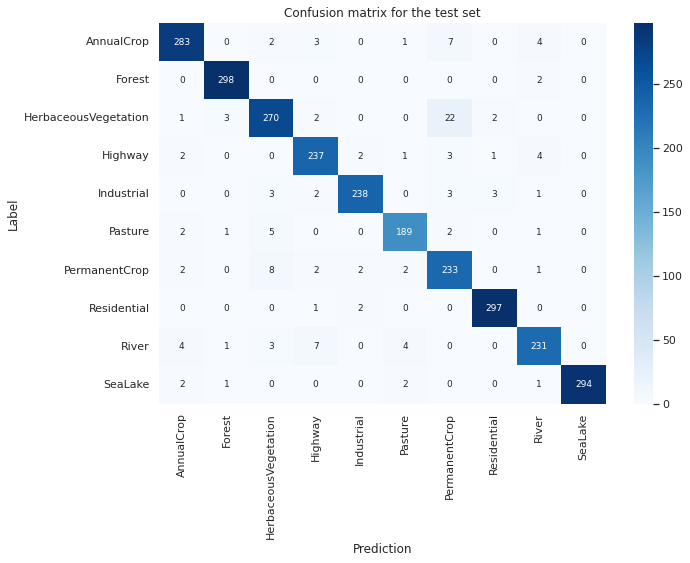

<Figure size 432x288 with 0 Axes>

In [24]:
plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.title("Confusion matrix for the test set")
plt.show()
plt.savefig(output_folder + model_name + "_confusion.png")

In [25]:
results_df = pd.DataFrame(
    {
        "label": test_set.labels, 
        "prediction": predicted_class_ids, 
        "path": test_set.filepaths
    }
)

mistakes = results_df["label"] != results_df["prediction"]
mistakes_df = results_df[mistakes]

wrong_preds = len(mistakes_df)
tot_preds = len(results_df)

print(f"{wrong_preds} wrong predictions out of {tot_preds}")

130 wrong predictions out of 2700


In [26]:
# Add results to the results csv file:
print("---------SAVE RESULTS---------")

with open("./results.csv", 'a+', newline='') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    # Create a row with the column names:
    filewriter.writerow([model,
                         model_name, 
                         loss,
                         accuracy,
                         wa_prec,
                         wa_rec,
                         wa_f1,
                         wrong_preds,
                         tot_preds,
                         batch_size,
                         len(training_df), # number of images in the training set
                         len(validation_df), # number of images in the validation set
                         len(test_df), # number of images in the test set
                         n_epochs, # cap set for num epochs
                         n_ran_epochs # epoch where it stopped automatically
                        ])
    

---------SAVE RESULTS---------


# START ABLATION STUDY

In [27]:
def run_model(model, model_name):
    model_path = "/kaggle/working/eurosat_rgb_" + model_name + ".h5"
    # Save the weigths of the best model
    checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
    # Reduce learning rate when val_loss stops improving for 5 epochs.
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)
    # Stop training if a val_loss has stopped improving for 5 epochs.
    early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=verbose)
    callback_list = [checkpoint, early_stopping, reduce_lr]
    
    print("---------MODEL COMPILE---------")
    model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

    print("---------MODEL FIT---------")
    history = model.fit(
        training_set,
        validation_data=validation_set,
        callbacks=callback_list,
        epochs=n_epochs,
        verbose=verbose,
    )

    return history

In [28]:
def get_eval_metrics(history, model, test_set):
    print("---------MODEL EVALUATE---------")
    n_ran_epochs = len(history.history['loss'])
    loss, accuracy = model.evaluate(test_set, verbose=verbose)
    test_set.reset()
    predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=verbose)
    predicted_class_ids = np.argmax(predicted_probabilities, axis=1)
    report = metrics.classification_report(test_set.labels, predicted_class_ids, output_dict=True)
    wa_prec = report["weighted avg"]["precision"]
    wa_rec = report["weighted avg"]["recall"]
    wa_f1 = report["weighted avg"]["f1-score"]
    cf_matrix = confusion_matrix(test_set.labels, predicted_class_ids)
    confusion_matrix_df = pd.DataFrame(
        data=cf_matrix, 
        index=class_name_list, 
        columns=class_name_list
    )
    results_df = pd.DataFrame(
        {
            "label": test_set.labels, 
            "prediction": predicted_class_ids, 
            "path": test_set.filepaths
        }
        )

    mistakes = results_df["label"] != results_df["prediction"]
    mistakes_df = results_df[mistakes]
    wrong_preds = len(mistakes_df)
    tot_preds = len(results_df)

    print(metrics.classification_report(test_set.labels, predicted_class_ids, digits=4))
    
    return n_ran_epochs, loss, accuracy, wa_prec, wa_rec, wa_f1, cf_matrix, confusion_matrix_df, wrong_preds, tot_preds

    
    
def save_plots(history, output_folder, model_name, confusion_matrix_df):
    plt.subplot(1, 2, 1)
    # Loss
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Loss - " + model_name)
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Accuracy - " + model_name)
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")

    #plt.show()
    plt.savefig(output_folder + model_name + "_training_curves.png")
    
    # CONFUSION MATRIX IMAGE
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1)
    sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
    plt.ylabel("Label")
    plt.xlabel("Prediction")
    plt.title("Confusion matrix - " + model_name)
    #plt.show()
    plt.savefig(output_folder + model_name + "_confusion.png")


In [29]:
def append_results_to_csv(csv_row):
    print("---------SAVE RESULTS---------")
    """Append the results to the csv file
    csv_row: list, contains the information to append to the csv"""
    
    with open("./results.csv", 'a+', newline='') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        # Create a row with the column names:
        filewriter.writerow(csv_row)

## Ablate CONV 1

---------ABLATION CONV 1---------
---------MODEL COMPILE---------
---------MODEL FIT---------
---------MODEL EVALUATE---------
              precision    recall  f1-score   support

           0     0.9558    0.9367    0.9461       300
           1     0.9934    0.9967    0.9950       300
           2     0.9470    0.9533    0.9502       300
           3     0.9673    0.9480    0.9576       250
           4     0.9756    0.9600    0.9677       250
           5     0.9372    0.9700    0.9533       200
           6     0.9163    0.9200    0.9182       250
           7     0.9867    0.9867    0.9867       300
           8     0.9294    0.9480    0.9386       250
           9     0.9933    0.9900    0.9917       300

    accuracy                         0.9619      2700
   macro avg     0.9602    0.9609    0.9605      2700
weighted avg     0.9620    0.9619    0.9619      2700

---------SAVE RESULTS---------


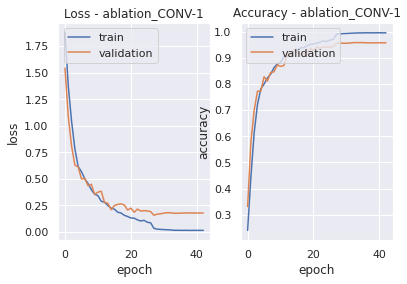

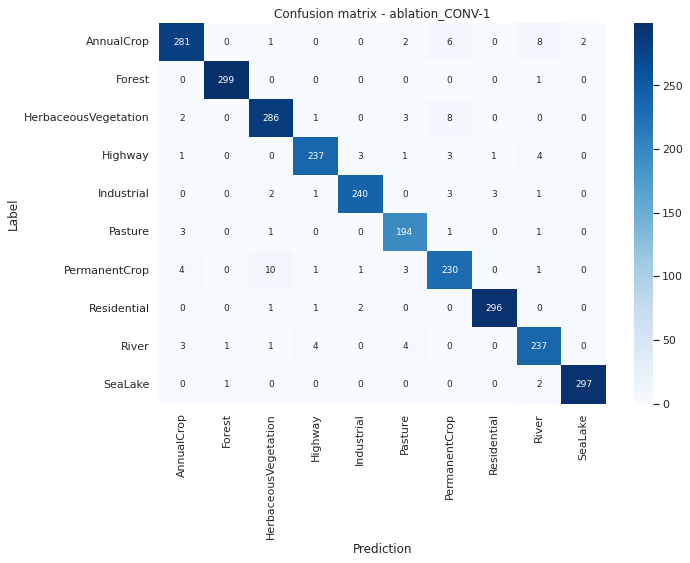

In [30]:
print("---------ABLATION CONV 1---------")

model_name = "ablation_CONV-1"
model = Sequential()

# start of model
#model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# add a flatten out layer, a dropout for regularization, a FC layer, and a final
# 10-node softmax layer for the prediction.
model.add(Flatten()) # just flattening operation, same numb. nodes kept
# n. nodes chosen by keeping the drop in nodes ratio of the origina model (approx.)
model.add(Dense(units=680, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5)) # MY ADDITION
model.add(Dense(units=180, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))


history = run_model(model, model_name)

n_ran_epochs, loss, accuracy, wa_prec, wa_rec, wa_f1, cf_matrix, confusion_matrix_df, wrong_preds, tot_preds = get_eval_metrics(history, model, test_set)

save_plots(history, output_folder, model_name, confusion_matrix_df)
cv_row = [model,
         model_name, 
         loss,
         accuracy,
         wa_prec,
         wa_rec,
         wa_f1,
         wrong_preds,
         tot_preds,
         batch_size,
         len(training_df), # number of images in the training set
         len(validation_df), # number of images in the validation set
         len(test_df), # number of images in the test set
         n_epochs, # cap set for num epochs
         n_ran_epochs # epoch where it stopped automatically
        ]

append_results_to_csv(cv_row)

## Ablate CONV 2

---------ABLATION CONV 2---------
---------MODEL COMPILE---------
---------MODEL FIT---------
---------MODEL EVALUATE---------
              precision    recall  f1-score   support

           0     0.9567    0.9567    0.9567       300
           1     0.9900    0.9933    0.9917       300
           2     0.9589    0.9333    0.9459       300
           3     0.9680    0.9680    0.9680       250
           4     0.9879    0.9760    0.9819       250
           5     0.9372    0.9700    0.9533       200
           6     0.8966    0.9360    0.9159       250
           7     0.9900    0.9867    0.9883       300
           8     0.9676    0.9560    0.9618       250
           9     1.0000    0.9867    0.9933       300

    accuracy                         0.9667      2700
   macro avg     0.9653    0.9663    0.9657      2700
weighted avg     0.9671    0.9667    0.9668      2700

---------SAVE RESULTS---------


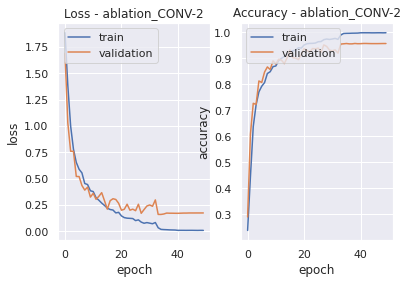

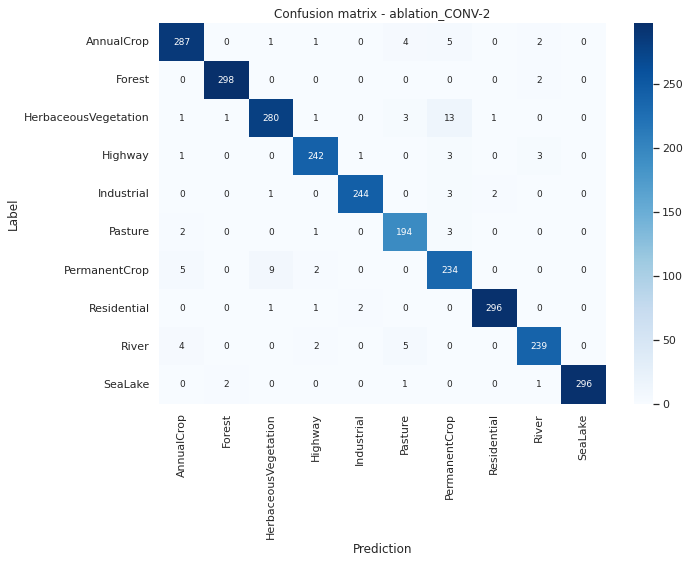

In [31]:
print("---------ABLATION CONV 2---------")

model_name = "ablation_CONV-2"
model = Sequential()

# start of model
model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# add a flatten out layer, a dropout for regularization, a FC layer, and a final
# 10-node softmax layer for the prediction.
model.add(Flatten()) # just flattening operation, same numb. nodes kept
# n. nodes chosen by keeping the drop in nodes ratio of the origina model (approx.)
model.add(Dense(units=680, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5)) # MY ADDITION
model.add(Dense(units=180, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))


history = run_model(model, model_name)

n_ran_epochs, loss, accuracy, wa_prec, wa_rec, wa_f1, cf_matrix, confusion_matrix_df, wrong_preds, tot_preds = get_eval_metrics(history, model, test_set)

save_plots(history, output_folder, model_name, confusion_matrix_df)
cv_row = [model,
         model_name, 
         loss,
         accuracy,
         wa_prec,
         wa_rec,
         wa_f1,
         wrong_preds,
         tot_preds,
         batch_size,
         len(training_df), # number of images in the training set
         len(validation_df), # number of images in the validation set
         len(test_df), # number of images in the test set
         n_epochs, # cap set for num epochs
         n_ran_epochs # epoch where it stopped automatically
        ]

append_results_to_csv(cv_row)

## Ablate CONV 3

---------ABLATION CONV 3---------
---------MODEL COMPILE---------
---------MODEL FIT---------
---------MODEL EVALUATE---------
              precision    recall  f1-score   support

           0     0.9371    0.9433    0.9402       300
           1     0.9770    0.9933    0.9851       300
           2     0.9472    0.8967    0.9212       300
           3     0.9508    0.9280    0.9393       250
           4     0.9717    0.9600    0.9658       250
           5     0.9314    0.9500    0.9406       200
           6     0.8821    0.9280    0.9045       250
           7     0.9900    0.9933    0.9917       300
           8     0.9246    0.9320    0.9283       250
           9     0.9966    0.9900    0.9933       300

    accuracy                         0.9526      2700
   macro avg     0.9509    0.9515    0.9510      2700
weighted avg     0.9530    0.9526    0.9526      2700

---------SAVE RESULTS---------


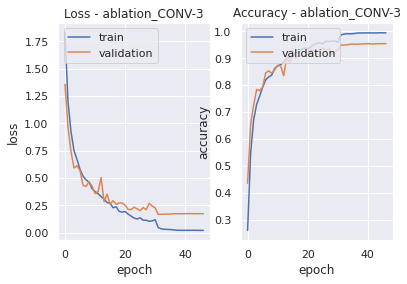

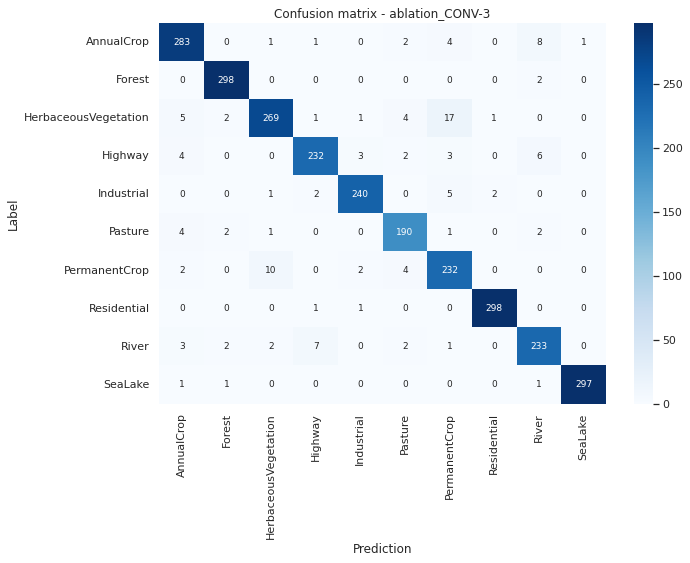

In [32]:
print("---------ABLATION CONV 3---------")
model_name = "ablation_CONV-3"
model = Sequential()

# start of model
model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# add a flatten out layer, a dropout for regularization, a FC layer, and a final
# 10-node softmax layer for the prediction.
model.add(Flatten()) # just flattening operation, same numb. nodes kept
# n. nodes chosen by keeping the drop in nodes ratio of the origina model (approx.)
model.add(Dense(units=680, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5)) # MY ADDITION
model.add(Dense(units=180, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))


history = run_model(model, model_name)

n_ran_epochs, loss, accuracy, wa_prec, wa_rec, wa_f1, cf_matrix, confusion_matrix_df, wrong_preds, tot_preds = get_eval_metrics(history, model, test_set)

save_plots(history, output_folder, model_name, confusion_matrix_df)
cv_row = [model,
         model_name, 
         loss,
         accuracy,
         wa_prec,
         wa_rec,
         wa_f1,
         wrong_preds,
         tot_preds,
         batch_size,
         len(training_df), # number of images in the training set
         len(validation_df), # number of images in the validation set
         len(test_df), # number of images in the test set
         n_epochs, # cap set for num epochs
         n_ran_epochs # epoch where it stopped automatically
        ]

append_results_to_csv(cv_row)

## Ablate CONV 4

---------ABLATION CONV 4---------
---------MODEL COMPILE---------
---------MODEL FIT---------
---------MODEL EVALUATE---------
              precision    recall  f1-score   support

           0     0.9597    0.9533    0.9565       300
           1     0.9803    0.9933    0.9868       300
           2     0.9459    0.9333    0.9396       300
           3     0.9440    0.9440    0.9440       250
           4     0.9567    0.9720    0.9643       250
           5     0.9347    0.9300    0.9323       200
           6     0.9200    0.9200    0.9200       250
           7     0.9769    0.9867    0.9818       300
           8     0.9317    0.9280    0.9299       250
           9     1.0000    0.9900    0.9950       300

    accuracy                         0.9570      2700
   macro avg     0.9550    0.9551    0.9550      2700
weighted avg     0.9570    0.9570    0.9570      2700

---------SAVE RESULTS---------


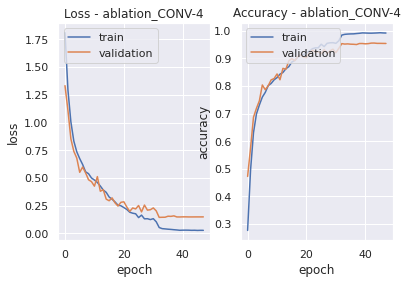

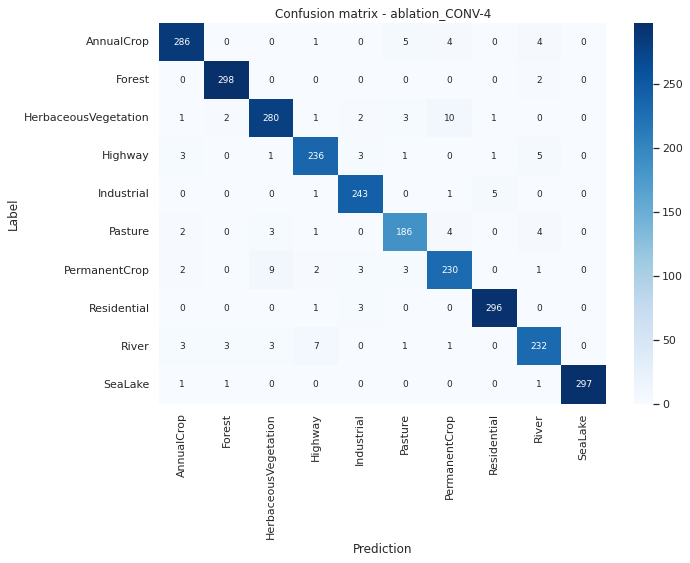

In [33]:
print("---------ABLATION CONV 4---------")
model_name = "ablation_CONV-4"
model = Sequential()

# start of model
model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# add a flatten out layer, a dropout for regularization, a FC layer, and a final
# 10-node softmax layer for the prediction.
model.add(Flatten()) # just flattening operation, same numb. nodes kept
# n. nodes chosen by keeping the drop in nodes ratio of the origina model (approx.)
model.add(Dense(units=680, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5)) # MY ADDITION
model.add(Dense(units=180, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))


history = run_model(model, model_name)

n_ran_epochs, loss, accuracy, wa_prec, wa_rec, wa_f1, cf_matrix, confusion_matrix_df, wrong_preds, tot_preds = get_eval_metrics(history, model, test_set)

save_plots(history, output_folder, model_name, confusion_matrix_df)
cv_row = [model,
         model_name, 
         loss,
         accuracy,
         wa_prec,
         wa_rec,
         wa_f1,
         wrong_preds,
         tot_preds,
         batch_size,
         len(training_df), # number of images in the training set
         len(validation_df), # number of images in the validation set
         len(test_df), # number of images in the test set
         n_epochs, # cap set for num epochs
         n_ran_epochs # epoch where it stopped automatically
        ]

append_results_to_csv(cv_row)

## Ablate CONV 5

---------ABLATION CONV 5---------
---------MODEL COMPILE---------
---------MODEL FIT---------
---------MODEL EVALUATE---------
              precision    recall  f1-score   support

           0     0.9498    0.9467    0.9482       300
           1     0.9868    0.9933    0.9900       300
           2     0.9329    0.9267    0.9298       300
           3     0.9398    0.9360    0.9379       250
           4     0.9958    0.9560    0.9755       250
           5     0.9450    0.9450    0.9450       200
           6     0.9062    0.9280    0.9170       250
           7     0.9771    0.9967    0.9868       300
           8     0.9173    0.9320    0.9246       250
           9     1.0000    0.9867    0.9933       300

    accuracy                         0.9563      2700
   macro avg     0.9551    0.9547    0.9548      2700
weighted avg     0.9566    0.9563    0.9564      2700

---------SAVE RESULTS---------


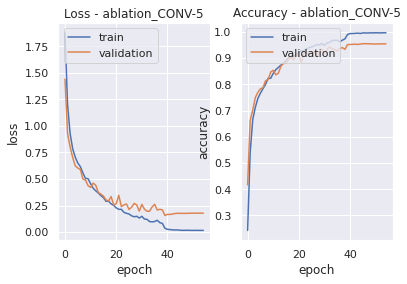

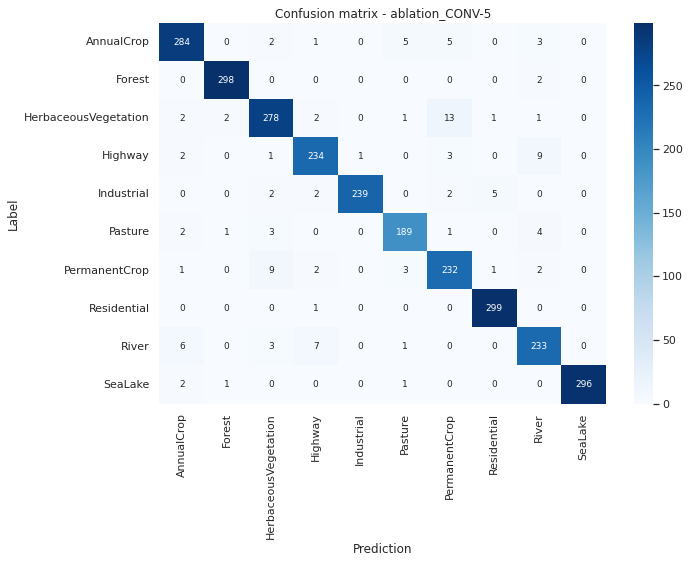

In [34]:
print("---------ABLATION CONV 5---------")
model_name = "ablation_CONV-5"
model = Sequential()

model.add(Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# add a flatten out layer, a dropout for regularization, a FC layer, and a final
# 10-node softmax layer for the prediction.
model.add(Flatten()) # just flattening operation, same numb. nodes kept
# n. nodes chosen by keeping the drop in nodes ratio of the origina model (approx.)
model.add(Dense(units=680, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.5)) # MY ADDITION
model.add(Dense(units=180, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))


history = run_model(model, model_name)

n_ran_epochs, loss, accuracy, wa_prec, wa_rec, wa_f1, cf_matrix, confusion_matrix_df, wrong_preds, tot_preds = get_eval_metrics(history, model, test_set)

save_plots(history, output_folder, model_name, confusion_matrix_df)
cv_row = [model,
         model_name, 
         loss,
         accuracy,
         wa_prec,
         wa_rec,
         wa_f1,
         wrong_preds,
         tot_preds,
         batch_size,
         len(training_df), # number of images in the training set
         len(validation_df), # number of images in the validation set
         len(test_df), # number of images in the test set
         n_epochs, # cap set for num epochs
         n_ran_epochs # epoch where it stopped automatically
        ]

append_results_to_csv(cv_row)